## Simulated Annealing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### About Simulated Annealing
The Simulated Annealing algorithm draws its inspiration from Physical Annealing in which a metal is heated up, and molded into a desired shape before it cools down and hardens.

Simulated Annealing is similar and is used to search global optima for functions. It tries to explore the given space as much as possible before it settles at the region of the global optima. This algorithm works best where gradient-based algorithms like Gradient Descent and Newton's Descent would perform poorly.


### Solving Optimization Problems
The solution to these problems would be to construct a Markov Chain whose steady state distribution is a point mass at the global optimum of the function. Simulated Annealing is the Monte Carlo method to solve optimization problems.


### Simulated Annealing Algorithm
#### Setup for the algorithm
1. Let x be an element in space S and let h(x) be a function defined over S such that<br>
    h: S $\rightarrow {\rm I\!R}$
2. The idea is to simulate a Markov Chain whose steady state distribution ($\pi$(x)) is a point mass at the global minima.
3. Let S* = {x $\in$ S: h(x) = $min_x$(h(x))}. We shall define $\pi$(x) to be a uniform distribution over $S^*$.<br>
    *Note: $\pi(x) = 0; \forall x \not\in S^*$*
4. Define an approximate density function $\pi_T(x) = exp(-\frac{h(x)}{T})$, where T is the "temperature".
5. Intialize T to a large value. *This is equivalent to heating up the metal to make it flexible.*
6. Choose a symmetric proposal density function $q(.|x_n)$ where n is the iteration number. Then follow the below the samplin procedure.

#### Algorithm
1. Begin the process by sampling an independent random number. Let this be $x_n$.
2. Sample $x$* $\sim q(x|x_n)$.
3. Sample $u \sim Uniform(0, 1)$.
4. Compute the below expression with the current $x^*$ and $x_n$.<br>
    $\alpha(x^*|x_n) = min(exp(-\frac{h(x^*) - h(x_n)}{T}), 1)$
5. Decrease the value of T according to a cooling schedule.
6. Go back to step 2 and repeat until convergence.

### Simulated Annealing Implementation

In [2]:
class SimulatedAnnealing:
    """
    The Simulated Annealing Monte Carlo method for optimizing functions.
    
    This uses the inverse logarithmic function for the cooling schedule.
    
    """
    def __init__(self, func, coef1, coef2, n_iters=300, intermediate=False):
        self.func = func
        self.a = coef1
        self.b = coef2
        self.n_iters = n_iters
        self.intermediate = intermediate
    
    def T(self, n):
        return self.a / np.log(n + self.b)
    
    def alpha(self, x_prev, x_curr, curr_T):
        exponent = self.func(x_curr) - self.func(x_prev)
        a = np.exp(-exponent / curr_T)
        return min(a, 1)
    
    def run(self):
        """The proposal distribution q(x) is the Gaussian distribution"""
        intermediate_results = []
        
        # Initialize process with one random number
        x_prev = np.random.uniform() * np.random.randint(2, 8)
        
        for i in range(self.n_iters):
            curr_temp = self.T(i) # get current iteration temperature
            x_curr = np.random.normal(loc=x_prev) # generate potential acceptance
            u = np.random.uniform()
            
            alpha = self.alpha(x_prev, x_curr, curr_temp)
            
            # acceptance criteria
            if u <= alpha:
                x_prev = x_curr
                intermediate_results.append(x_prev)
        
        # after all iterations, x_prev stores the last computed result
        if self.intermediate:
            return sum(intermediate_results) / len(intermediate_results), intermediate_results
        else:
            return sum(intermediate_results) / len(intermediate_results)

### Function to optimize

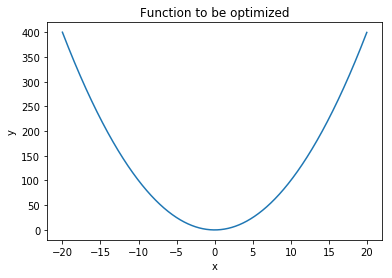

In [3]:
func = lambda x: x ** 2
theo_optim = 0

x = np.arange(-20, 20, 0.01)
y = func(x)

_ = plt.plot(x, y)
_ = plt.xlabel("x")
_ = plt.ylabel("y")
# _ = plt.ylim(-5, 10)
_ = plt.title("Function to be optimized")

### Results

The plot below shows the value of estimated point of global optima and the theoretical optima at each iteration.
Based on the plot, we can say that it has converged well.

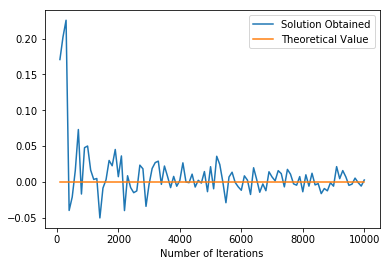

In [4]:
NUM_ITER_RANGE = range(100, 10001, 100)
all_sols = []

for num_iter in NUM_ITER_RANGE:
    sa = SimulatedAnnealing(func, 3, 4, num_iter)
    all_sols.append(sa.run())


_ = plt.plot(NUM_ITER_RANGE, all_sols, label="Solution Obtained")
_ = plt.plot(NUM_ITER_RANGE, [theo_optim] * len(all_sols), label="Theoretical Value")
_ = plt.xlabel("Number of Iterations")
_ = plt.legend()

### Path of the algorithm
The figure below shows the path that the algorithm took on the function's "landscape".

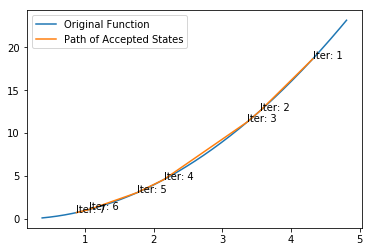

In [5]:
sa2 = SimulatedAnnealing(func, 3, 4, 10, True)
sol, path = sa2.run()

sample_x = np.arange(min(path) - 0.5, max(path) + 0.5, 0.01)
y = np.vectorize(func)(sample_x)

_ = plt.plot(sample_x, y, label="Original Function")
_ = plt.plot(path, np.vectorize(func)(path), label="Path of Accepted States")

for i, x in enumerate(path, 1):
    _ = plt.annotate(s=f"Iter: {i}", xy=(x, func(x)))
_ = plt.legend()

## Simulated Annealing for TSP

### Travelling Salesman Problem
The problem is to find a path that touches all cities such that the total cost of travelling is minimum.

For simplicity, I assumed the cost to travel from one city to another city is the absolute difference of their indices.<br>
i.e. Cost of travelling from City 3 to City 6 will be 3.

I am also representing each element in our state space as a list of the cities whic will represent the visiting order of the cities by the salesman.

Below is the implementation of Simulated Annealing for TSP.

In [6]:
import random
from copy import deepcopy

*The implementation for this problem is almost the same as the one above with only a few minor tweaks to account a different type of state space.*

In [7]:
class SimulatedAnnealingTSP(SimulatedAnnealing):
    def __init__(self, n_cities, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_cities = n_cities
    
    def run(self):
        intermediate_results = []
        intermediate_costs = []
        x_prev = list(range(1, self.n_cities + 1))
        random.shuffle(x_prev)
        
        for i in range(self.n_iters):
            curr_temp = self.T(i) # get current iteration temperature

            # x_curr = np.random.normal(loc=x_prev) # generate potential acceptance
            swap_indices = random.sample(range(self.n_cities), 2)
            x_curr = deepcopy(x_prev)
            x_curr[swap_indices[0]], x_curr[swap_indices[1]] = x_curr[swap_indices[1]], x_curr[swap_indices[0]]
            u = np.random.uniform()
            
            alpha = self.alpha(x_prev, x_curr, curr_temp)
            
            # acceptance criteria
            if u <= alpha:
                x_prev = x_curr
                intermediate_results.append(x_prev)
                intermediate_costs.append(self.func(x_prev))
        
        # after all iterations, x_prev stores the last computed result
        if self.intermediate:
            return x_prev, intermediate_results, intermediate_costs
        else:
            return x_prev

In [8]:
# The cost function defined for this problem.
def cost_func(x):
    cost = 0
    for i in range(1, len(x)):
        cost += abs(x[i] - x[i - 1])
    
    return cost


# Running the algorithm for TSP
sa4 = SimulatedAnnealingTSP(5, cost_func, 3, 4, n_iters=10, intermediate=True)
sol = sa4.run()
print(sol[0])

[2, 3, 4, 5, 1]


Below is printed the path of accepted states to the state of minimum cost

In [9]:
for state, cost in zip(*sol[1:]):
    print(f"Visit Order: {state}; Cost: {cost}")

Visit Order: [1, 4, 2, 3, 5]; Cost: 8
Visit Order: [2, 4, 1, 3, 5]; Cost: 9
Visit Order: [1, 4, 2, 3, 5]; Cost: 8
Visit Order: [2, 4, 1, 3, 5]; Cost: 9
Visit Order: [2, 4, 5, 3, 1]; Cost: 7
Visit Order: [2, 3, 5, 4, 1]; Cost: 7
Visit Order: [2, 3, 4, 5, 1]; Cost: 7


## Notable points

The approximate density function $\pi_T(x)$ has two properties:<br>
1. As $T \rightarrow \infty$, it approaches a uniform distribution over the entire state space.
2. As $T \rightarrow 0$, it approaches the density function $\pi(x)$, which will give us the global optima.


Another point is that we will always accept x* when $h(x^*) \leq h(x_n)$, thus going "downhill" on the function landscape and therefore minimizing it. x* is accepted with some probability if $h(x^*) > h(x_n)$, thus allowing the algorithm to explore more of the landscape. This probability goes down as T approaches 0 therefore restricting the algorithm to explore around the minima.

Also, an appropiate "cooling schedule" must be chosen to decrease the value of T over time or over each iteration. It must satisfy the following properties.
1. It must be monotonically decreasing.
2. It must be always positive.
From these two properties, we can infer that T = 0 must be an asymptote for the function.<br>
Typically, a function such as the one below is used, which is as follows.<br>
T(n) = $\frac{a}{\log(n + b)}$<br>
where n: iteration number<br>
a, b: real numbers

This algorithm converges slowly because of two reasons:<br>
1. The cooling schedule for T has a logarithm in the denominator. Due to this, T decreases slowly over time.
2. Although with some probability, the algorithm still accepts points where the value of the function is greater(or going "uphill"). Due to this, there is a chance, it might steer away from the objective and may or may not come back later.

Despite these problems, the advantage of Simulated Annealing is that its randomness and ability to accept points that go "uphill" prevents it from being stuck in local minima, unlike gradient-based optimization algorithms.